In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


In [3]:
# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
# Define Hyperparameter
BATCH_SIZE = 64;
LEARNING_RATE = 0.0001;
NUM_EPOCHS = 50;

In [5]:
# Set transform to normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
# DataLoading
train_dataset = datasets.MNIST(
    '~/datasets',
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.MNIST(
    '~/datasets',
    train=False,
    transform=transform,
    download=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [7]:
# Data size check
data = iter(train_dataloader)
samples, labels = next(data)
print(f"number of samples: {samples.shape}")
print(f"number of labels: {labels.shape}")

number of samples: torch.Size([64, 1, 28, 28])
number of labels: torch.Size([64])


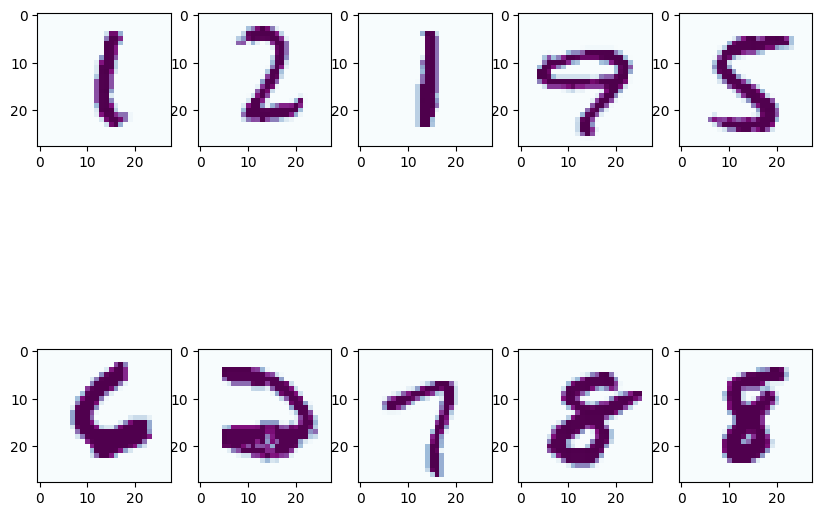

In [8]:
# Show sample data
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(samples[i][0], cmap='BuPu')
plt.show()

In [9]:
class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim):
        super().__init__()

        num_patches = (image_size // patch_size) ** 2
        # patch_dim = 1 * patch_size ** 2

        # Patching and Linear Projection
        self.patch_to_embedding = nn.Sequential(
            nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size), # Shape: (B, C, H/patch_size, W/patch_size)
            nn.Flatten(2), # Shape: (B, dim, num_patches)
        )

        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Learnable Positional Embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=depth
        )

        # MLP Head for classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # Image shape: (B, C, H, W)

        # Create patch embeddings
        x = self.patch_to_embedding(img) # Shape: (B, dim, num_patches)
        x = torch.transpose(x, 1, 2) # Shape: (B, num_patches, dim)
        B, _, _ = x.shape

        # Prepend the CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1) # Shape: (B, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1) # Shape: (B, num_patches + 1, dim)

        # Add positional embeddings
        x = x + self.pos_embedding # Shape: (B, num_patches + 1, dim)

        # Pass through the Transformer Encoder
        x = self.transformer_encoder(x) # Shape: (B, num_patches + 1, dim)

        # Extract the CLS token's output for classification
        cls_output = x[:, 0]

        # Pass through the final classifier
        return self.mlp_head(cls_output)

In [10]:
model = SimpleViT(
    image_size=28,  # MNIST image size
    patch_size=2,   # Patch size
    num_classes=10, # Number of classes in MNIST (0-9)
    dim=64,         # Embedding dimension
    depth=6,        # Number of Transformer blocks
    heads=8,        # Number of attention heads
    mlp_dim=128     # Dimension of the MLP in Transformer blocks
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [11]:
# Loss and testset accuracy list
loss_list, test_accuracy_list = [], []

In [12]:
# Training loop
print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}")
    loss_list.append(avg_loss)

    # Eval
    print("Evaluating on test data...")
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    test_accuracy_list.append(accuracy)

print("\nFinished Training!")


Starting training...


Epoch 1/50, Loss: 1.4237
Evaluating on test data...
Test Accuracy: 83.35%


Epoch 2/50, Loss: 0.5142
Evaluating on test data...
Test Accuracy: 90.02%


Epoch 3/50, Loss: 0.3646
Evaluating on test data...
Test Accuracy: 91.94%


Epoch 4/50, Loss: 0.2943
Evaluating on test data...
Test Accuracy: 92.85%


Epoch 5/50, Loss: 0.2539
Evaluating on test data...
Test Accuracy: 94.14%


Epoch 6/50, Loss: 0.2253
Evaluating on test data...
Test Accuracy: 94.36%


Epoch 7/50, Loss: 0.2050
Evaluating on test data...
Test Accuracy: 95.17%


Epoch 8/50, Loss: 0.1889
Evaluating on test data...
Test Accuracy: 95.31%


Epoch 9/50, Loss: 0.1723
Evaluating on test data...
Test Accuracy: 95.55%


Epoch 10/50, Loss: 0.1572
Evaluating on test data...
Test Accuracy: 95.55%


Epoch 11/50, Loss: 0.1504
Evaluating on test data...
Test Accuracy: 96.17%


Epoch 12/50, Loss: 0.1373
Evaluating on test data...
Test Accuracy: 96.45%


Epoch 13/50, Loss: 0.1291
Evaluating on test data...
Test Accuracy: 96.74%


Epoch 14/50, Loss: 0.1239
Evaluating on test data...
Test Accuracy: 96.70%


Epoch 15/50, Loss: 0.1153
Evaluating on test data...
Test Accuracy: 96.68%


Epoch 16/50, Loss: 0.1095
Evaluating on test data...
Test Accuracy: 97.00%


Epoch 17/50, Loss: 0.1047
Evaluating on test data...
Test Accuracy: 97.31%


Epoch 18/50, Loss: 0.1014
Evaluating on test data...
Test Accuracy: 96.64%


Epoch 19/50, Loss: 0.0966
Evaluating on test data...
Test Accuracy: 97.22%


Epoch 20/50, Loss: 0.0907
Evaluating on test data...
Test Accuracy: 97.33%


Epoch 21/50, Loss: 0.0902
Evaluating on test data...
Test Accuracy: 97.31%


Epoch 22/50, Loss: 0.0860
Evaluating on test data...
Test Accuracy: 97.39%


Epoch 23/50, Loss: 0.0838
Evaluating on test data...
Test Accuracy: 97.34%


Epoch 24/50, Loss: 0.0768
Evaluating on test data...
Test Accuracy: 97.27%


Epoch 25/50, Loss: 0.0769
Evaluating on test data...
Test Accuracy: 97.54%


Epoch 26/50, Loss: 0.0729
Evaluating on test data...
Test Accuracy: 97.63%


Epoch 27/50, Loss: 0.0701
Evaluating on test data...
Test Accuracy: 97.72%


Epoch 28/50, Loss: 0.0675
Evaluating on test data...
Test Accuracy: 97.84%


Epoch 29/50, Loss: 0.0649
Evaluating on test data...
Test Accuracy: 97.70%


Epoch 30/50, Loss: 0.0633
Evaluating on test data...
Test Accuracy: 97.78%


Epoch 31/50, Loss: 0.0606
Evaluating on test data...
Test Accuracy: 97.67%


Epoch 32/50, Loss: 0.0583
Evaluating on test data...
Test Accuracy: 97.79%


Epoch 33/50, Loss: 0.0561
Evaluating on test data...
Test Accuracy: 98.04%


Epoch 34/50, Loss: 0.0556
Evaluating on test data...
Test Accuracy: 97.90%


Epoch 35/50, Loss: 0.0531
Evaluating on test data...
Test Accuracy: 98.03%


Epoch 36/50, Loss: 0.0512
Evaluating on test data...
Test Accuracy: 97.84%


Epoch 37/50, Loss: 0.0509
Evaluating on test data...
Test Accuracy: 97.94%


Epoch 38/50, Loss: 0.0466
Evaluating on test data...
Test Accuracy: 98.02%


Epoch 39/50, Loss: 0.0472
Evaluating on test data...
Test Accuracy: 97.92%


Epoch 40/50, Loss: 0.0456
Evaluating on test data...
Test Accuracy: 98.01%


Epoch 41/50, Loss: 0.0437
Evaluating on test data...
Test Accuracy: 98.01%


Epoch 42/50, Loss: 0.0436
Evaluating on test data...
Test Accuracy: 98.08%


Epoch 43/50, Loss: 0.0413
Evaluating on test data...
Test Accuracy: 98.08%


Epoch 44/50, Loss: 0.0402
Evaluating on test data...
Test Accuracy: 98.24%


Epoch 45/50, Loss: 0.0393
Evaluating on test data...
Test Accuracy: 98.12%


Epoch 46/50, Loss: 0.0377
Evaluating on test data...
Test Accuracy: 98.23%


Epoch 47/50, Loss: 0.0374
Evaluating on test data...
Test Accuracy: 98.15%


Epoch 48/50, Loss: 0.0344
Evaluating on test data...
Test Accuracy: 98.13%


Epoch 49/50, Loss: 0.0359
Evaluating on test data...
Test Accuracy: 98.27%


Epoch 50/50, Loss: 0.0326
Evaluating on test data...
Test Accuracy: 98.07%

Finished Training!


In [21]:
model.eval()
final_test_loss = 0.0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        final_test_loss += loss.item()

final_test_loss /= len(test_dataloader)
print(f"Final Test Loss: {final_test_loss:.4f}")

Final Test Loss: 0.0628


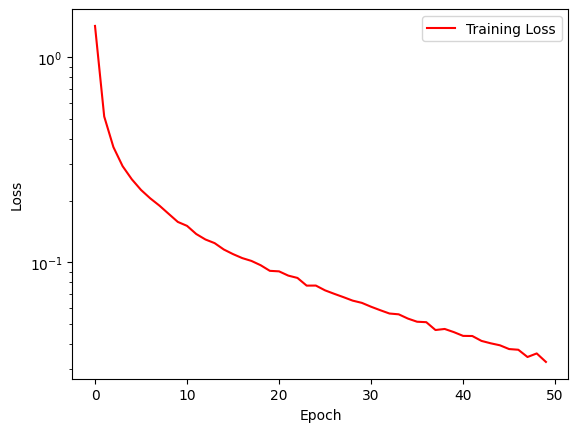

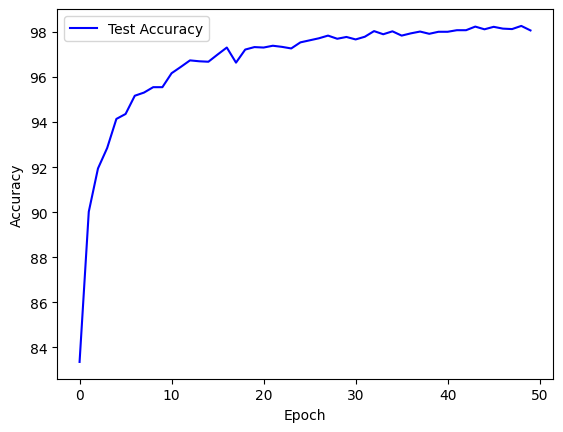

In [13]:
# Loss and Test Accuracy Plot
plt.plot(range(len(loss_list)), loss_list, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(range(len(test_accuracy_list)), test_accuracy_list, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()